# Load data

In [1]:
import sage
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Load data
df = sage.datasets.bank()

# Convert binary features to 0/1
binary_cols = ['Default', 'Housing', 'Loan']
for col in binary_cols:
    df[col] = (df[col] == 'yes').astype(float)
    
# Convert education to numerical
df['Education'].replace(
    {'unknown': 0, 'primary': 1, 'secondary': 2, 'tertiary': 3},
    inplace=True)

# Convert month to numerical
df['Month'].replace(
    {'jan': 0, 'feb': 1, 'mar': 2, 'apr': 3, 'may': 4, 'jun': 5,
     'jul': 6, 'aug': 7, 'sep': 8, 'oct': 9, 'nov': 10, 'dec': 11},
    inplace=True)

# Convert marital to one-hot
for value in np.unique(df['Marital'].values):
    df['Marital-{}'.format(value)] = (df['Marital'] == value).astype(float)
df.drop(columns='Marital', inplace=True)

# Convert contact to one-hot
for value in np.unique(df['Contact'].values):
    df['Contact-{}'.format(value)] = (df['Contact'] == value).astype(float)
df.drop(columns='Contact', inplace=True)

# Convert prev outcome to one-hot
for value in np.unique(df['Prev Outcome'].values):
    df['Prev Outcome-{}'.format(value)] = (df['Prev Outcome'] == value).astype(float)
df.drop(columns='Prev Outcome', inplace=True)

# Convert job to one-hot
for value in np.unique(df['Job'].values):
    df['Job-{}'.format(value)] = (df['Job'] == value).astype(float)
df.drop(columns='Job', inplace=True)

# Split into X, Y
values = df.values.astype(float)
X_cols = np.array(df.columns) != 'Success'
X, Y = values[:, X_cols], values[:, ~X_cols]

# Get feature names, groups
feature_names = np.array(df.columns)[X_cols]
prefixes = np.array([name.split('-')[0] for name in feature_names])
groups = []
group_names = []
for prefix in np.unique(prefixes):
    groups.append(np.where(prefixes == prefix)[0])
    group_names.append(prefix)

# Train/val/test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.1, random_state=123)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.1, random_state=123)

In [3]:
# Standardize continuous columns
feature_names = list(feature_names)
num_features = len(feature_names)
continuous_cols = ['Age', 'Balance', 'Day', 'Duration', 'Campaign',
                   'Month', 'Prev Days', 'Prev Contacts']
continuous_inds = [feature_names.index(col) for col in continuous_cols]
ss = StandardScaler()
ss.fit(X_train[:, continuous_inds])
X_train[:, continuous_inds] = ss.transform(X_train[:, continuous_inds])
X_val[:, continuous_inds] = ss.transform(X_val[:, continuous_inds])
X_test[:, continuous_inds] = ss.transform(X_test[:, continuous_inds])

# Set up imputer

In [4]:
import torch
import torch.nn as nn
from fastshap_torch.utils import BaselineImputer

In [5]:
device = torch.device('cuda', 1)
model = torch.load('../models/bank_model.pt').eval().to(device=device)

In [6]:
# Set up baseline
baseline = np.zeros((1, num_features))

# Determine values for continuous features
for col in continuous_cols:
    if col == 'Month':
        continue
    ind = feature_names.index(col)
    baseline[0, ind] = np.mean(X_train[:, ind])
    
# Determine values for binary features
for col in binary_cols:
    ind = feature_names.index(col)
    baseline[0, ind] = (np.mean(X_train[:, ind]) > 0.5)
    
# Determine values for numerical features
for col in ('Education', 'Month'):
    ind = feature_names.index(col)
    values, counts = np.unique(X_train[:, ind], return_counts=True)
    baseline[0, ind] = values[np.argmax(counts)]
    
# Determine values for one-hot features
unique_prefixes, prefix_counts = np.unique(prefixes, return_counts=True)
repeat_prefixes = unique_prefixes[prefix_counts > 1]
for prefix in repeat_prefixes:
    inds = np.where(prefixes == prefix)[0]
    max_ind = np.argmax(np.mean(X_train[:, inds], axis=0))
    baseline[0, inds[max_ind]] = 1

# Set up imputer
imputer = BaselineImputer(model, baseline, groups=groups)

# Load SHAP values

In [7]:
import pickle
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from fastshap_torch import FastSHAP

In [8]:
with open('../results/bank_baseline_shap.pkl', 'rb') as f:
    shap_values = np.array(pickle.load(f))

In [9]:
def euclidean_dist(values, target):
    return np.sqrt(np.sum((values - target) ** 2, axis=(-2, -1)))

def l1_dist(values, target):
    return np.sum(np.abs(values - target), axis=(-2, -1))

# Samples plot

- Using normalization and the efficiency gap penalty, test different # training samples

In [10]:
# Standard sampling
num_samples = (1, 4, 16, 32, 48, 64)
standard_results = []

for samples in num_samples:
    # Load explainer
    explainer = torch.load('../models/bank_baseline_explainer samples={} nopenalty.pt'.format(samples))
    explainer.eval()
    explainer.to(device=device)
    
    # Set up FastSHAP object
    fastshap = FastSHAP(explainer, imputer, normalization='additive', link=nn.Sigmoid())
    
    # Generate explanations
    pred = fastshap.shap_values(X_test[:len(shap_values)])
    standard_results.append(pred)

# Paired sampling
num_paired_samples = (4, 16, 32, 48, 64)
paired_results = []

for samples in num_paired_samples:
    # Load explainer
    explainer = torch.load('../models/bank_baseline_explainer paired_samples={} nopenalty.pt'.format(samples))
    explainer.eval()
    explainer.to(device=device)
    
    # Set up FastSHAP object
    fastshap = FastSHAP(explainer, imputer, normalization='additive', link=nn.Sigmoid())
    
    # Generate explanations
    pred = fastshap.shap_values(X_test[:len(shap_values)])
    paired_results.append(pred)

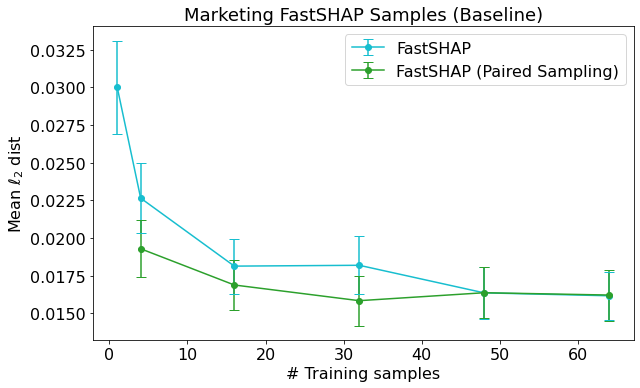

In [11]:
plt.figure(figsize=(9, 5.5))

# Standard sampling
dist_list = [euclidean_dist(results, shap_values) for results in standard_results]
mean_list = [np.mean(dist) for dist in dist_list]
std_list = [np.std(dist) / np.sqrt(len(shap_values)) for dist in dist_list]
# plt.plot(num_samples, mean_list,
#          marker='o', color='tab:cyan', label='FastSHAP')
# plt.fill_between(num_samples, np.array(mean_list) + 1.96 * np.array(std_list),
#                  np.array(mean_list) - 1.96 * np.array(std_list),
#                  color='tab:cyan', alpha=0.1)
plt.errorbar(num_samples, mean_list, yerr=1.96 * np.array(std_list),
             capsize=5, marker='o', color='tab:cyan', label='FastSHAP')

# Paired sampling
dist_list = [euclidean_dist(results, shap_values) for results in paired_results]
mean_list = [np.mean(dist) for dist in dist_list]
std_list = [np.std(dist) / np.sqrt(len(shap_values)) for dist in dist_list]
plt.errorbar(num_paired_samples, mean_list, yerr=1.96 * np.array(std_list),
             capsize=5, marker='o', color='tab:green', label='FastSHAP (Paired Sampling)')

# Formatting
plt.legend(loc='upper right', fontsize=16)
plt.xlabel('# Training samples', fontsize=16)
plt.ylabel(r'Mean $\ell_2$ dist', fontsize=16)
plt.title('Marketing FastSHAP Samples (Baseline)', fontsize=18)
plt.tick_params(labelsize=16)

plt.tight_layout()
# plt.show()
plt.savefig('../figures/bank_baseline_samples.pdf')

# Ablation results

- For a fixed number of samples (with paired sampling), test the normalization layer and the efficiency gap penalty

In [12]:
ablation_results = [
    # {'filename': '../models/bank_baseline_explainer nopenalty.pt', 'name': 'FastSHAP (Norm)'},
    {'filename': '../models/bank_baseline_explainer paired_samples=32 nopenalty.pt', 'name': 'FastSHAP (Norm)'},
    {'filename': '../models/bank_baseline_explainer paired_samples=32.pt', 'name': 'FastSHAP (Norm, Penalty)'},
    {'filename': '../models/bank_baseline_explainer nopenalty nonormalization.pt', 'name': 'FastSHAP (Inference Norm)'},
    {'filename': '../models/bank_baseline_explainer nonormalization.pt', 'name': 'FastSHAP (Inference Norm, Penalty)'},
    {'filename': '../models/bank_baseline_explainer nopenalty nonormalization.pt', 'name': 'FastSHAP (No Norm)'},
    {'filename': '../models/bank_baseline_explainer nonormalization.pt', 'name': 'FastSHAP (No Norm, Penalty)'},
]

for ablation in ablation_results:
    # Load explainer
    explainer = torch.load(ablation['filename'])
    explainer.eval()
    explainer.to(device=device)
    
    # Set up FastSHAP object
    if 'No Norm' in ablation['name']:
        normalization = None
    else:
        normalization = 'additive'
    fastshap = FastSHAP(explainer, imputer, normalization=normalization, link=nn.Sigmoid())
    
    # Generate explanations
    pred = fastshap.shap_values(X_test[:len(shap_values)])
    ablation['results'] = pred

In [13]:
print(r' & $\ell_2$ & $\ell_1$')

for ablation in ablation_results:
    # Calculate distance
    l2 = euclidean_dist(ablation['results'], shap_values)
    l1 = l1_dist(ablation['results'], shap_values)
    
    # Print results
    print('{} & {:.4f} & {:.4f}'.format(ablation['name'], np.mean(l2), np.mean(l1)))

 & $\ell_2$ & $\ell_1$
FastSHAP (Norm) & 0.0158 & 0.0473
FastSHAP (Norm, Penalty) & 0.0170 & 0.0520
FastSHAP (Inference Norm) & 0.0230 & 0.0707
FastSHAP (Inference Norm, Penalty) & 0.0213 & 0.0665
FastSHAP (No Norm) & 0.0243 & 0.0746
FastSHAP (No Norm, Penalty) & 0.0222 & 0.0688


In [14]:
print(r' & $\ell_2$ & $\ell_1$')

for ablation in ablation_results:
    # Calculate distance
    l2 = euclidean_dist(ablation['results'], shap_values)
    l1 = l1_dist(ablation['results'], shap_values)
    
    # Print results
    print('{} & {:.4f} $\pm$ {:.4f} & {:.4f} $\pm$ {:.4f}'.format(
        ablation['name'],
        np.mean(l2), 1.96 * np.std(l2) / np.sqrt(len(shap_values)),
        np.mean(l1), 1.96 * np.std(l1) / np.sqrt(len(shap_values))))

 & $\ell_2$ & $\ell_1$
FastSHAP (Norm) & 0.0158 $\pm$ 0.0017 & 0.0473 $\pm$ 0.0049
FastSHAP (Norm, Penalty) & 0.0170 $\pm$ 0.0016 & 0.0520 $\pm$ 0.0051
FastSHAP (Inference Norm) & 0.0230 $\pm$ 0.0022 & 0.0707 $\pm$ 0.0066
FastSHAP (Inference Norm, Penalty) & 0.0213 $\pm$ 0.0021 & 0.0665 $\pm$ 0.0065
FastSHAP (No Norm) & 0.0243 $\pm$ 0.0023 & 0.0746 $\pm$ 0.0068
FastSHAP (No Norm, Penalty) & 0.0222 $\pm$ 0.0022 & 0.0688 $\pm$ 0.0066


# Curve comparison

In [15]:
# Load curves
with open('../results/bank_baseline_curves.pkl', 'rb') as f:
    save_dict = pickle.load(f)
    
kernelshap_curves = save_dict['kernelshap']
kernelshap_iters = save_dict['kernelshap_iters']

paired_curves = save_dict['paired_sampling']
paired_iters = save_dict['paired_sampling_iters']

sampling_curves = save_dict['sampling_curves']
sampling_iters = save_dict['sampling_iters']

antithetical_curves = save_dict['antithetical_curves']
antithetical_iters = save_dict['antithetical_iters']

In [16]:
# Load FastSHAP
explainer = torch.load('../models/bank_baseline_explainer paired_samples=32 nopenalty.pt')
explainer.eval()
explainer.to(device=device)

# Set up FastSHAP object
fastshap = FastSHAP(explainer, imputer, normalization='additive', link=nn.Sigmoid())

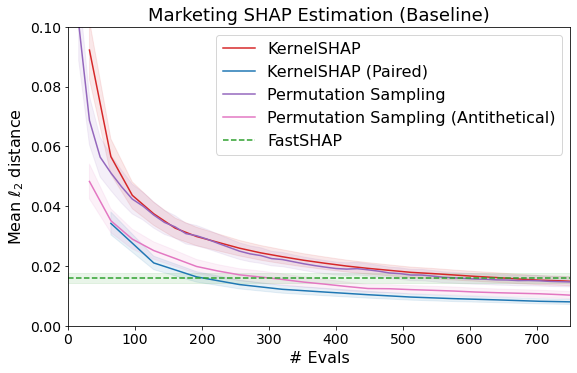

In [17]:
plt.figure(figsize=(9, 5.5))

# KernelSHAP
dist = euclidean_dist(kernelshap_curves, shap_values[:, np.newaxis])
skip_inds = 0
plt.plot(kernelshap_iters[skip_inds:], np.mean(dist, axis=0)[skip_inds:],
         label='KernelSHAP', color='tab:red')
plt.fill_between(kernelshap_iters[skip_inds:],
                 (np.mean(dist, axis=0) - 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)))[skip_inds:],
                 (np.mean(dist, axis=0) + 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)))[skip_inds:],
                 color='tab:red', alpha=0.1)

# KernelSHAP (paired sampling)
dist = euclidean_dist(paired_curves, shap_values[:, np.newaxis])
skip_inds = 0
plt.plot(paired_iters[skip_inds:], np.mean(dist, axis=0)[skip_inds:],
         label='KernelSHAP (Paired)', color='tab:blue')
plt.fill_between(paired_iters[skip_inds:],
                 (np.mean(dist, axis=0) - 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)))[skip_inds:],
                 (np.mean(dist, axis=0) + 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)))[skip_inds:],
                 color='tab:blue', alpha=0.1)

# Permutation sampling
dist = euclidean_dist(sampling_curves, shap_values[:, np.newaxis])
plt.plot(sampling_iters, np.mean(dist, axis=0),
         label='Permutation Sampling', color='tab:purple')
plt.fill_between(sampling_iters,
                 np.mean(dist, axis=0) - 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)),
                 np.mean(dist, axis=0) + 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)),
                 color='tab:purple', alpha=0.1)

# Antithetical sampling
dist = euclidean_dist(antithetical_curves, shap_values[:, np.newaxis])
plt.plot(antithetical_iters, np.mean(dist, axis=0),
         label='Permutation Sampling (Antithetical)', color='tab:pink')
plt.fill_between(antithetical_iters,
                 np.mean(dist, axis=0) - 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)),
                 np.mean(dist, axis=0) + 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)),
                 color='tab:pink', alpha=0.1)

# FastSHAP
pred = fastshap.shap_values(X_test[:len(shap_values)])
dist = euclidean_dist(pred, shap_values)
plt.axhline(np.mean(dist), label='FastSHAP', color='tab:green', linestyle='--')
plt.fill_between([0, 2100],
                 [np.mean(dist, axis=0) - 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)),
                  np.mean(dist, axis=0) - 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values))],
                 [np.mean(dist, axis=0) + 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)),
                  np.mean(dist, axis=0) + 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values))],
                 color='tab:green', alpha=0.1)

# Formatting
plt.ylim(0, 0.1)
plt.xlim(0, 750)
plt.legend(fontsize=16)
plt.tick_params(labelsize=14)
plt.ylabel(r'Mean $\ell_2$ distance', fontsize=16)
plt.xlabel('# Evals', fontsize=16)
plt.title('Marketing SHAP Estimation (Baseline)', fontsize=18)

# plt.show()
plt.savefig('../figures/bank_baseline_l2_curves.pdf')

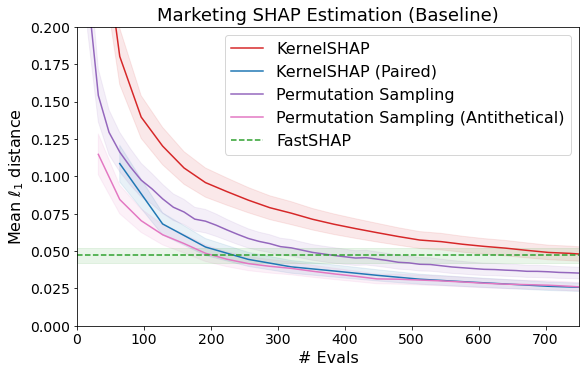

In [18]:
plt.figure(figsize=(9, 5.5))

# KernelSHAP
dist = l1_dist(kernelshap_curves, shap_values[:, np.newaxis])
skip_inds = 0
plt.plot(kernelshap_iters[skip_inds:], np.mean(dist, axis=0)[skip_inds:],
         label='KernelSHAP', color='tab:red')
plt.fill_between(kernelshap_iters[skip_inds:],
                 (np.mean(dist, axis=0) - 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)))[skip_inds:],
                 (np.mean(dist, axis=0) + 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)))[skip_inds:],
                 color='tab:red', alpha=0.1)

# KernelSHAP (paired sampling)
dist = l1_dist(paired_curves, shap_values[:, np.newaxis])
skip_inds = 0
plt.plot(paired_iters[skip_inds:], np.mean(dist, axis=0)[skip_inds:],
         label='KernelSHAP (Paired)', color='tab:blue')
plt.fill_between(paired_iters[skip_inds:],
                 (np.mean(dist, axis=0) - 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)))[skip_inds:],
                 (np.mean(dist, axis=0) + 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)))[skip_inds:],
                 color='tab:blue', alpha=0.1)

# Permutation sampling
dist = l1_dist(sampling_curves, shap_values[:, np.newaxis])
plt.plot(sampling_iters, np.mean(dist, axis=0),
         label='Permutation Sampling', color='tab:purple')
plt.fill_between(sampling_iters,
                 np.mean(dist, axis=0) - 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)),
                 np.mean(dist, axis=0) + 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)),
                 color='tab:purple', alpha=0.1)

# Antithetical sampling
dist = l1_dist(antithetical_curves, shap_values[:, np.newaxis])
plt.plot(antithetical_iters, np.mean(dist, axis=0),
         label='Permutation Sampling (Antithetical)', color='tab:pink')
plt.fill_between(antithetical_iters,
                 np.mean(dist, axis=0) - 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)),
                 np.mean(dist, axis=0) + 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)),
                 color='tab:pink', alpha=0.1)

# FastSHAP
pred = fastshap.shap_values(X_test[:len(shap_values)])
dist = l1_dist(pred, shap_values)
plt.axhline(np.mean(dist), label='FastSHAP', color='tab:green', linestyle='--')
plt.fill_between([0, 2100],
                 [np.mean(dist, axis=0) - 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)),
                  np.mean(dist, axis=0) - 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values))],
                 [np.mean(dist, axis=0) + 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)),
                  np.mean(dist, axis=0) + 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values))],
                 color='tab:green', alpha=0.1)

# Formatting
plt.ylim(0, 0.2)
plt.xlim(0, 750)
plt.legend(fontsize=16)
plt.tick_params(labelsize=14)
plt.ylabel(r'Mean $\ell_1$ distance', fontsize=16)
plt.xlabel('# Evals', fontsize=16)
plt.title('Marketing SHAP Estimation (Baseline)', fontsize=18)

# plt.show()
plt.savefig('../figures/bank_baseline_l1_curves.pdf')

# Catch up plot

- Botplot of # model evaluations required to catch up to FastSHAP

In [19]:
# Get FastSHAP distances
fast_dist = euclidean_dist(pred, shap_values)

# Set up baselines
catchup_results = [
    {'name': 'KernelSHAP', 'estimates': kernelshap_curves, 'iters': kernelshap_iters},
    {'name': 'KernelSHAP (Paired)', 'estimates': paired_curves, 'iters': paired_iters},
    {'name': 'Sampling', 'estimates': sampling_curves, 'iters': sampling_iters},
    {'name': 'Sampling (Anti)', 'estimates': antithetical_curves, 'iters': antithetical_iters}
]

# Calculate number of iterations required for each baseline
for results in catchup_results:
    # Calculate distance
    estimates = results['estimates']
    iters = results['iters']
    dist = euclidean_dist(estimates, shap_values[:, np.newaxis])
    
    # Find index where distance becomes smaller
    smaller = dist < fast_dist[:, np.newaxis]
    smaller[:, -1] = True
    index = np.argmax(smaller, axis=1)
    results['catchup_iters'] = iters[index]

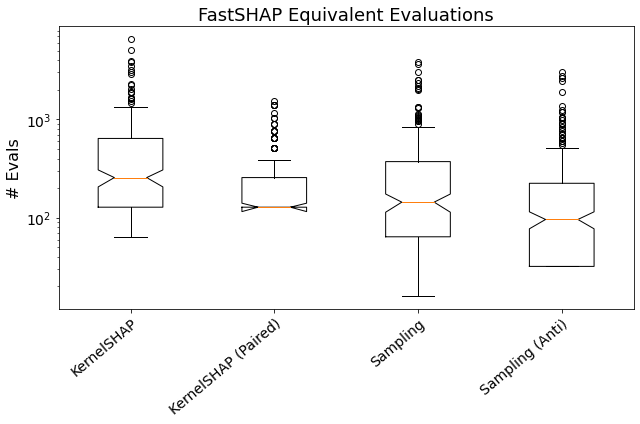

In [20]:
plt.figure(figsize=(9, 6))

# Plot
plt.boxplot([results['catchup_iters'] for results in catchup_results],
            notch=True, vert=True)
plt.xticks(1 + np.arange(len(catchup_results)), [results['name'] for results in catchup_results],
           rotation=40, ha='right', rotation_mode='anchor')

# Formatting
plt.ylabel('# Evals', fontsize=16)
plt.yscale('log')
plt.title('FastSHAP Equivalent Evaluations', fontsize=18)
plt.tick_params(labelsize=14)

plt.tight_layout()
plt.show()

In [19]:
# Calculate mean catchup time
catchup_results = {}

# FastSHAP
pred = fastshap.shap_values(X_test[:len(shap_values)])
dist = euclidean_dist(pred, shap_values)
mean_dist = np.mean(dist)

# KernelSHAP
iters = kernelshap_iters
dist = np.mean(euclidean_dist(kernelshap_curves, shap_values[:, np.newaxis]), axis=0)
ind = np.where(dist < mean_dist)[0][0]
if ind == 0:
    # Minimum number of iterations
    catchup_results['KernelSHAP'] = iters[ind]
else:
    # Linear interpolation
    w = (dist[ind - 1] - mean_dist) / (dist[ind - 1] - dist[ind])
    catchup_results['KernelSHAP'] = iters[ind - 1] + w * (iters[ind] - iters[ind - 1])

# KernelSHAP (paired sampling)
iters = paired_iters
dist = np.mean(euclidean_dist(paired_curves, shap_values[:, np.newaxis]), axis=0)
ind = np.where(dist < mean_dist)[0][0]
if ind == 0:
    # Minimum number of iterations
    catchup_results['KernelSHAP (Paired)'] = iters[ind]
else:
    # Linear interpolation
    w = (dist[ind - 1] - mean_dist) / (dist[ind - 1] - dist[ind])
    catchup_results['KernelSHAP (Paired)'] = iters[ind - 1] + w * (iters[ind] - iters[ind - 1])

# Permutation sampling
iters = sampling_iters
dist = np.mean(euclidean_dist(sampling_curves, shap_values[:, np.newaxis]), axis=0)
ind = np.where(dist < mean_dist)[0][0]
if ind == 0:
    # Minimum number of iterations
    catchup_results['Permutation Sampling'] = iters[ind]
else:
    # Linear interpolation
    w = (dist[ind - 1] - mean_dist) / (dist[ind - 1] - dist[ind])
    catchup_results['Permutation Sampling'] = iters[ind - 1] + w * (iters[ind] - iters[ind - 1])

# Anithetical sampling
iters = antithetical_iters
dist = np.mean(euclidean_dist(antithetical_curves, shap_values[:, np.newaxis]), axis=0)
ind = np.where(dist < mean_dist)[0][0]
if ind == 0:
    # Minimum number of iterations
    catchup_results['Permutation Sampling (Antithetical)'] = iters[ind]
else:
    # Linear interpolation
    w = (dist[ind - 1] - mean_dist) / (dist[ind - 1] - dist[ind])
    catchup_results['Permutation Sampling (Antithetical)'] = iters[ind - 1] + w * (iters[ind] - iters[ind - 1])

In [20]:
with open('../results/bank_baseline_catchup.pkl', 'wb') as f:
    pickle.dump(catchup_results, f)